In [1]:
import warnings  
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datetime import datetime, date, time, timedelta
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score, precision_score, roc_auc_score
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, InputLayer
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import backend as K
import h5py
import math

Using TensorFlow backend.


In [154]:
import geopandas

ModuleNotFoundError: No module named 'geopandas'

In [16]:
drivedir = '/content/gdrive'
datadir = drivedir + '/My Drive/data/' #directory for storing datasets

In [ ]:
from google.colab import drive
drive.mount(drivedir)

In [3]:
%pwd

'C:\\Users\\SSA3918C'

In [2]:
#fichero='query (14).csv' #USA
fichero='query20190601.csv'
#fichero='queryCuadrado.csv'
earthquake =pd.read_csv(fichero, sep=',')
earthquake.head(1)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2019-05-26T23:31:57.258Z,38.54,16.1676,6.51,4.1,mb,NaN,58.0,0.352,1.1,...,2019-05-27T09:23:45.948Z,"1km S of Melicucca, Italy",earthquake,4.3,5.7,0.186,8.0,reviewed,us,us


In [5]:
print ("número de terremotos:", earthquake.count()[0])

número de terremotos : 3608


In [7]:
print('Fecha inicial: ', earthquake['time'].min())
print('Fecha final: ', earthquake['time'].max())

Fecha inicial:  1973-01-30T02:36:11.600Z
Fecha final:  2019-05-26T23:31:57.258Z


In [3]:
earthquake['latitude'].describe()

count    3608.000000
mean       36.924525
std         2.063828
min        28.584000
25%        35.422750
50%        36.670000
75%        38.201375
max        41.743000
Name: latitude, dtype: float64

In [4]:
earthquake = earthquake.sort_values(by='time').reindex()

Text(0.5,1,'Magnitud de terremotos')

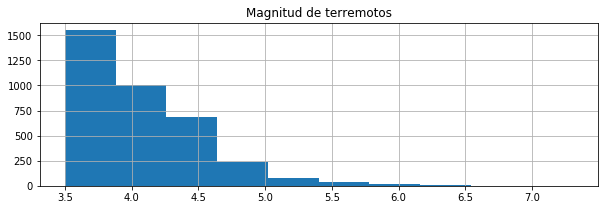

In [5]:
plt.figure(figsize=(10,3))
earthquake["mag"].hist() ##bins=4
plt.title('Magnitud de terremotos')

In [6]:
earthquake["mag"].describe()

count    3608.000000
mean        4.039967
std         0.475393
min         3.500000
25%         3.700000
50%         3.900000
75%         4.300000
max         7.300000
Name: mag, dtype: float64

In [8]:
# Separamos la variable "time" (YYYY-MM-DDThh:mm:ss.s) en "date" en formato YYYY-MM-DD
# y "time" sobreescrita en formato hh:mm:ss.s
earthquake["date"] = earthquake["time"].apply(lambda x: x.split("T")[0])
earthquake["time"] = earthquake["time"].apply(lambda x: x.split("Z")[0].split("T")[1])
earthquake[["date","time"]].head(1)

,date,time
3607,1973-01-30,02:36:11.600


In [9]:
#Vnw, Vsw, Vne, Vse
la_min = earthquake["latitude"].min()
print("Minimum Latitude: ",la_min)
la_max = earthquake["latitude"].max()
print("Maximum Latitude: ",la_max)
lo_min = earthquake["longitude"].min()
print("Minimum Longitude: ",lo_min)
lo_max = earthquake["longitude"].max()
print("Maximum Longitude: ",lo_max)

Minimum Latitude:  28.584
Maximum Latitude:  41.743
Minimum Longitude:  -17.019000000000002
Maximum Longitude:  17.925


In [10]:
#Vectores de posición que limitan el área de estudio: Vnw, Vsw, Vne, Vse
Vnw = (lo_min, la_max) #Northwest
Vsw = (lo_min, la_min) #Southwest
Vne = (lo_max, la_max) #Northeast
Vse = (lo_max, la_min) #Southeast
#Vnw, Vsw, Vne, Vse
print('Vnw: ',Vnw)
print('Vsw: ',Vsw)
print('Vne: ',Vne)
print('Vse: ',Vse)
# Número de subdivisiones por base y altura:
mb = 3
ma = 3
#Base y altura de las subáreas de estudio:
b = round(abs(lo_max - lo_min)/mb,4)
a = round(abs(la_max - la_min)/ma,4)
print("Altura: ", a, "Base: ", b)

Vnw:  (-17.019000000000002, 41.743)
Vsw:  (-17.019000000000002, 28.584)
Vne:  (17.925, 41.743)
Vse:  (17.925, 28.584)
Altura:  4.3863 Base:  11.648


In [11]:
earthquake["i"] = earthquake["latitude"].apply(lambda x: (x-la_min)/a)
earthquake["j"] = earthquake["longitude"].apply(lambda x: (x-lo_min)/b)
        
# earthquake["int_i"] = np.ceil(earthquake["i"])
# earthquake["int_j"] = np.ceil(earthquake["j"])

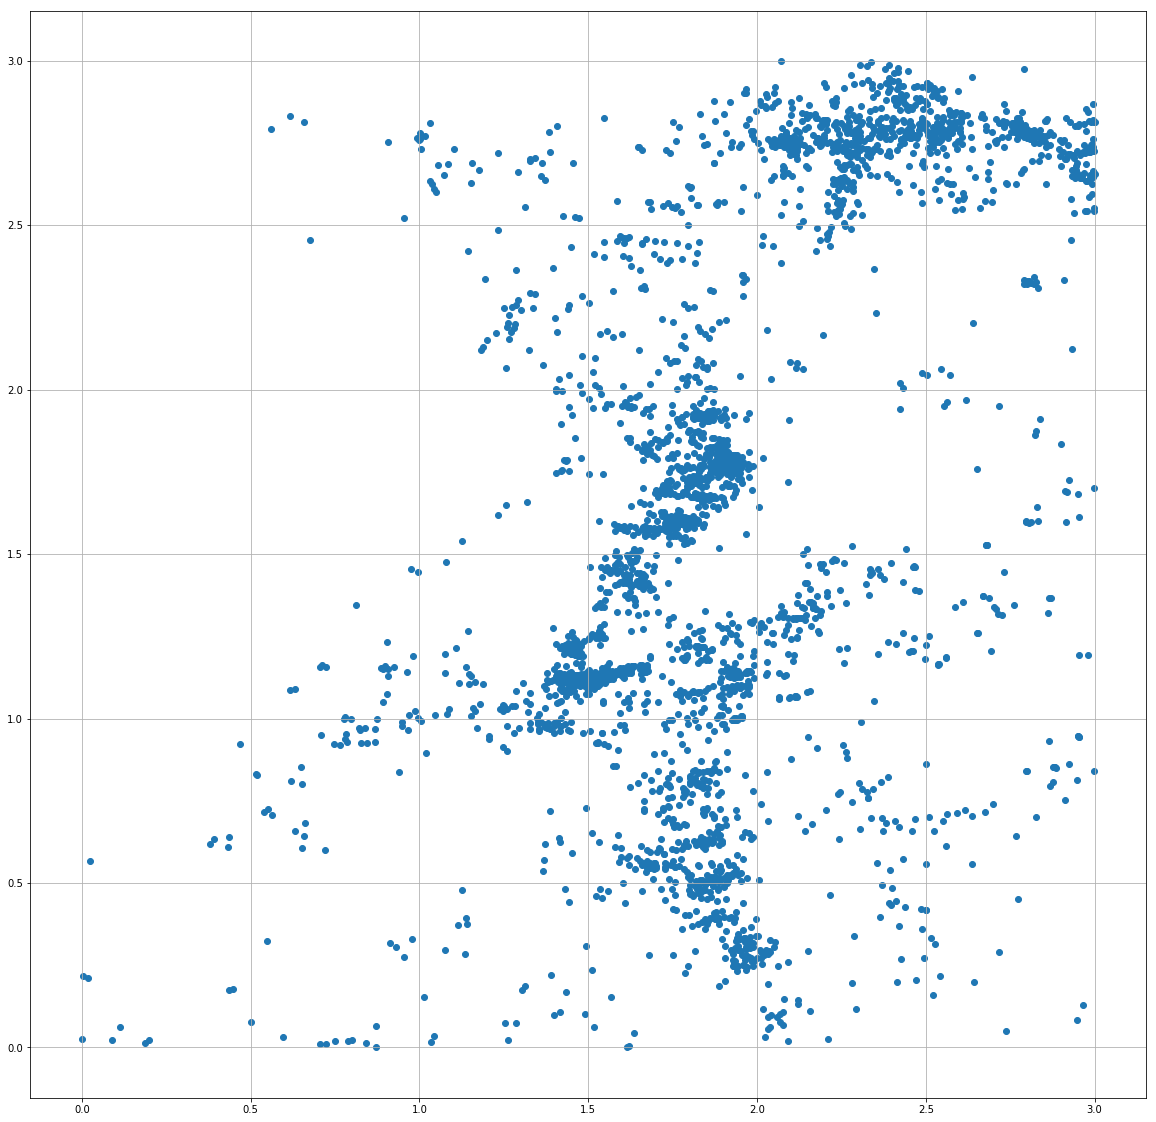

In [12]:
#plt.plot(earthquake["int_i"],earthquake["int_j"])
plt.figure(figsize=(20,20))
# plt.scatter(earthquake["int_i"],earthquake["int_j"])
plt.scatter(earthquake["i"],earthquake["j"])
plt.grid(True)
plt.show()

In [13]:
earthquake["k"] = 0.0
earthquake.loc[(earthquake.i < 1.0) & (earthquake.j < 1.0), 'k'] = 1.0
earthquake.loc[(earthquake.i < 1.0) & (1.0 <= earthquake.j) & (earthquake.j < 2.0), 'k'] = 2.0
earthquake.loc[(earthquake.i < 1.0) & (2.0 <= earthquake.j) & (earthquake.j < 3.0), 'k'] = 3.0
earthquake.loc[(1.0 <= earthquake.i) & (earthquake.i < 2.0) & (earthquake.j < 1.0), 'k'] = 4.0
earthquake.loc[(1.0 <= earthquake.i) & (earthquake.i < 2.0) & (1.0 <=earthquake.j) & (earthquake.j< 2.0), 'k'] = 5.0
earthquake.loc[(1.0 <= earthquake.i) & (earthquake.i < 2.0) & (2.0 <=earthquake.j) & (earthquake.j < 3.0), 'k'] = 6.0
earthquake.loc[(2.0 <= earthquake.i) & (earthquake.i < 3.0) & (earthquake.j < 1.0), 'k'] = 7.0
earthquake.loc[(2.0 <= earthquake.i) & (earthquake.i < 3.0) & (1.0 <=earthquake.j) & (earthquake.j < 2.0), 'k'] = 8.0
earthquake.loc[(2.0 <= earthquake.i) & (earthquake.i < 3.0) & (2.0 <=earthquake.j) & (earthquake.j <3.0), 'k'] = 9.0


In [14]:
earthquake

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,depthError,magError,magNst,status,locationSource,magSource,date,i,j,k
3607,02:36:11.600,37.0030,-3.6190,634.00,4.0,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,reviewed,us,us,1973-01-30,1.919385,1.150412,5.0
3606,04:24:15.100,36.2580,-7.2830,15.00,3.8,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,reviewed,us,us,1973-03-04,1.749538,0.835852,4.0
3605,08:12:15.400,39.0900,16.9610,45.00,4.7,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,reviewed,us,us,1973-04-13,2.395185,2.917239,9.0
3604,14:37:53.900,34.6420,-4.0730,19.00,4.6,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,reviewed,us,us,1973-04-29,1.381118,1.111435,5.0
3603,23:17:11.600,36.4710,-12.3260,33.00,4.4,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,reviewed,us,us,1973-05-02,1.798099,0.402902,4.0
3602,14:36:11.000,40.8220,15.3890,33.00,4.7,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,reviewed,us,us,1973-08-08,2.790051,2.782280,9.0
3601,10:50:59.700,36.2030,-2.0400,33.00,3.9,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,reviewed,us,us,1973-08-24,1.736999,1.285972,5.0
3600,01:14:06.000,41.7280,13.8690,33.00,4.4,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,reviewed,us,us,1973-10-30,2.996603,2.651786,9.0
3599,08:40:46.700,41.6820,13.7630,33.00,4.0,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,reviewed,us,us,1973-11-05,2.986116,2.642685,9.0
3598,14:05:46.400,36.1400,4.4080,17.00,5.1,ms,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,reviewed,us,us,1973-11-24,1.722636,1.839543,5.0


In [16]:
max_date = datetime.strptime(earthquake["date"].max(), '%Y-%m-%d')
min_date = datetime.strptime(earthquake["date"].min(), '%Y-%m-%d')
print(max_date)
print(min_date)

2019-05-26 00:00:00
1973-01-30 00:00:00


In [17]:
def diff_month(d1, d2):
    return np.ceil((d1 - d2).days / 14)

In [18]:
earthquake["quincena"] = earthquake.date.apply(lambda d: diff_month(datetime.strptime(d, '%Y-%m-%d'), min_date))

In [19]:
earthquake

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,magError,magNst,status,locationSource,magSource,date,i,j,k,quincena
3607,02:36:11.600,37.0030,-3.6190,634.00,4.0,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,reviewed,us,us,1973-01-30,1.919385,1.150412,5.0,0.0
3606,04:24:15.100,36.2580,-7.2830,15.00,3.8,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,reviewed,us,us,1973-03-04,1.749538,0.835852,4.0,3.0
3605,08:12:15.400,39.0900,16.9610,45.00,4.7,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,reviewed,us,us,1973-04-13,2.395185,2.917239,9.0,6.0
3604,14:37:53.900,34.6420,-4.0730,19.00,4.6,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,reviewed,us,us,1973-04-29,1.381118,1.111435,5.0,7.0
3603,23:17:11.600,36.4710,-12.3260,33.00,4.4,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,reviewed,us,us,1973-05-02,1.798099,0.402902,4.0,7.0
3602,14:36:11.000,40.8220,15.3890,33.00,4.7,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,reviewed,us,us,1973-08-08,2.790051,2.782280,9.0,14.0
3601,10:50:59.700,36.2030,-2.0400,33.00,3.9,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,reviewed,us,us,1973-08-24,1.736999,1.285972,5.0,15.0
3600,01:14:06.000,41.7280,13.8690,33.00,4.4,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,reviewed,us,us,1973-10-30,2.996603,2.651786,9.0,20.0
3599,08:40:46.700,41.6820,13.7630,33.00,4.0,mb,NaN,NaN,NaN,NaN,...,NaN,NaN,reviewed,us,us,1973-11-05,2.986116,2.642685,9.0,20.0
3598,14:05:46.400,36.1400,4.4080,17.00,5.1,ms,NaN,NaN,NaN,NaN,...,NaN,NaN,reviewed,us,us,1973-11-24,1.722636,1.839543,5.0,22.0


In [20]:
vectors = pd.DataFrame()
vectors = pd.crosstab(earthquake["k"], earthquake["quincena"]) #Cálculo de frecuencias
vectors

quincena,0.0,3.0,6.0,7.0,14.0,15.0,20.0,22.0,24.0,25.0,...,1188.0,1189.0,1190.0,1192.0,1194.0,1196.0,1198.0,1200.0,1202.0,1209.0
k,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5.0,1,0,0,1,0,1,0,3,0,0,...,0,0,0,0,0,0,0,0,1,0
6.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
8.0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [21]:
d = pd.DataFrame(np.zeros((1,int(earthquake["quincena"].max()))))
vectors = vectors.append(d)
vectors =  vectors.fillna(0.0)
vectors = vectors.T
vectors = vectors.iloc[:,1:10]
vectors

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
region = vectors.iloc[:,4]

In [16]:
print('queryCuadrado.csv - 0.0',region[region == 0.0].count())
print('queryCuadrado.csv - 1.0',region[region == 1.0].count())

NameError: name 'region' is not defined

In [24]:
porcentaje_no_terremotos = region[region == 0.0].count() * 100 / region.count()
print('porcentaje de terremotos: {:.4f}'.format(100 - porcentaje_no_terremotos))

porcentaje de terremotos: 40.0000


In [23]:
hoy = datetime.today().strftime('%Y%m%d')
# nombreFichero = 'vectors_Lorca3x3-{}.nb.csv'.format(hoy)
# #nombreFichero = 'vectors_mediterraneo3x3-20190608.csv'
# vectors.to_csv(path_or_buf=nombreFichero, index=False)

In [8]:
import pandas as pd
import numpy as np

In [2]:
#fullname = datadir + 'vectors_mediterraneo3x3-20190620.csv'
fullname = 'vectors_Lorca3x3-20190907.nb.csv'
vectors2 = pd.read_csv(fullname)
vectors2

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
vectors2.iloc[878:901]

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
878,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0
879,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0
880,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,1.0
881,0.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,4.0
882,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
883,0.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0
884,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,1.0
885,1.0,0.0,0.0,2.0,6.0,0.0,0.0,0.0,2.0
886,0.0,0.0,0.0,2.0,6.0,0.0,1.0,0.0,2.0
887,1.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0


In [21]:
pd.DataFrame(vectors2.iloc[879:902,4].apply(lambda x: 1 if x>0 else 0))

,5.0
879,1
880,1
881,1
882,0
883,0
884,1
885,1
886,1
887,1
888,1


In [17]:
print('patrones de entrada:', len(vectors2))
print('número de terremotos:', len(vectors2[vectors2['5.0'] > 0]))
print('ausencia de terremotos:', len(vectors2[vectors2['5.0'] == 0]))

patrones de entrada: 1210
número de terremotos: 484
ausencia de terremotos: 726


In [4]:
zona = 4
region = vectors2.iloc[:,zona]
region.describe()

count    1210.000000
mean        1.338843
std         6.350467
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       168.000000
Name: 5.0, dtype: float64

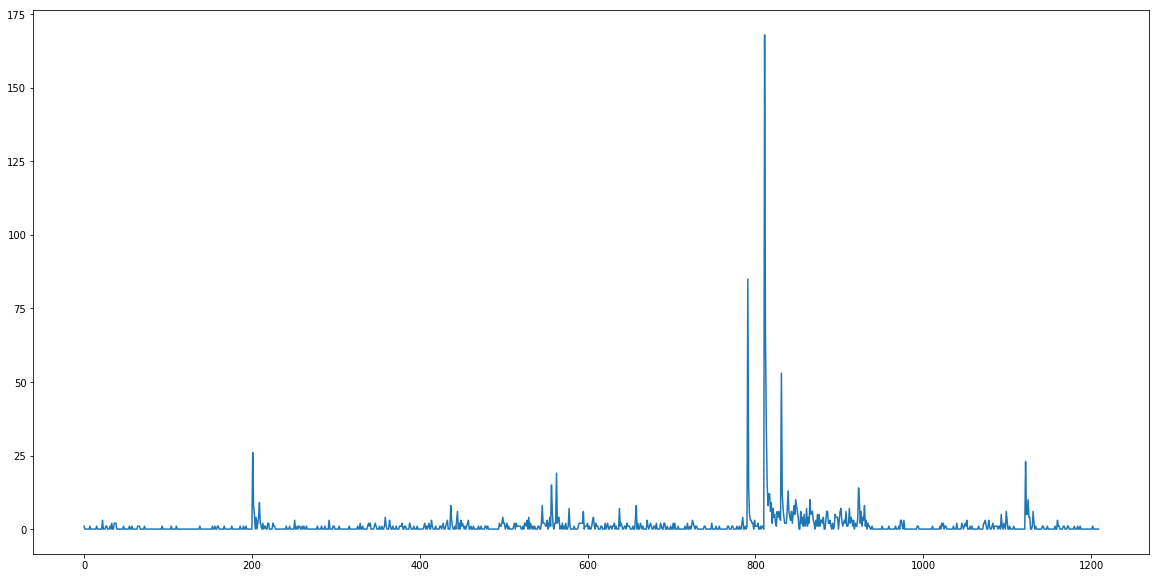

In [5]:
plt.figure(figsize=(20,10))
plt.plot(vectors2.iloc[:,zona])

### Creamos un diccionario con clave nombre del modelo y valor las métricas del modelo

In [6]:
metrics = dict()

In [7]:
region_central = vectors2.iloc[:,zona]
train_size = int(len(region_central) * 0.7)
train = region_central[0:train_size]
test_size = int(len(region_central) * 0.1) + train_size
test = region_central[train_size:test_size]
val = region_central[test_size:len(region_central)]

In [8]:
print('train_size: ', len(train))
print('test_size: ', len(test))
print('val_size: ', len(val))


len(train) + len(test) + len(val) == len(region_central)

train_size:  847
test_size:  121
val_size:  242


True

In [6]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    #scaler = MinMaxScaler()
    for i in range(len(dataset) - window_size - 1):
        a = dataset.values[i:i + window_size]
        data_X.append(a)       
        data_Y.append(dataset.iloc[i + window_size])
    X = np.array(data_X)
    #X = scaler.fit_transform(X)
    Y = np.array(data_Y)
    Y[Y > 1] = 1
    return X,Y

In [10]:
def DrawGraphcs(model):
    plt.figure(figsize=(20,5))
    plt.subplot(1, 2, 1)
    plt.plot(model.history.history['acc'])
    plt.plot(model.history.history['val_acc'])
    plt.subplot(1, 2, 2)
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])

In [11]:
def Metrics_LR(train_X, train_Y, test_X, test_Y, name, window_size):
    lr_train_X, lr_train_Y = train_X, train_Y
    lr_test_X, lr_test_Y = test_X, test_Y

    clf = LogisticRegression()
    clf.fit(lr_train_X, lr_train_Y)

    lr_y_pred = clf.predict(lr_test_X)

    acc = clf.score(lr_test_X, lr_test_Y)
    print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(acc))
    precision = precision_score(lr_test_Y, lr_y_pred)
    print('Precision of logistic regression classifier on test set: {:.4f}'.format(precision))
    recall = recall_score(lr_test_Y, lr_y_pred)
    print('Recall of logistic regression classifier on test set: {:.4f}'.format(recall))
    roc = roc_auc_score(lr_test_Y, lr_y_pred)
    print('Roc of logistic regression classifier on test set: {:.4f}'.format(roc))
    print('Training data shape:{}'.format(train_X.shape))
    print('Testing data shape:{}'.format(test_X.shape))
    metrics[name] = [window_size, train_X.shape, test_X.shape, acc, precision, recall, roc]

In [12]:
def Metrics_NN(model, model_name, test_X, test_Y, window_size):
    y_pred = model.predict(test_X).round()
    score, acc = model.evaluate(test_X, test_Y, batch_size=window_size)
    print('score: ', score)
    print('acc: ', acc)
    precision = precision_score(test_Y, y_pred)
    print('Precision: {:.4f}'.format(precision))
    recall = recall_score(test_Y, y_pred)
    print('Recall: {:.4f}'.format(recall))
    roc = roc_auc_score(test_Y, y_pred)
    print('ROC: {:.4f}'.format(roc))
    print('Training data shape:{}'.format(train_X.shape))
    print('Testing data shape:{}'.format(test_X.shape))
    metrics[model_name] = [model.count_params(), train_X.shape, test_X.shape, acc, precision, recall, roc]

In [24]:
def Save_model(model, model_name):
    hoy = datetime.today().strftime('%Y%m%d')
    model.name = model_name
    model.save('{}_{}.h5'.format(model.name,hoy))
    with open('{}_{}_history.json'.format(model.name,hoy), 'w') as f:
        json.dump(model.history.history, f)

### Estudio region central con ventana temporal de 1 quincena

In [14]:
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
val_X, val_Y = create_dataset(val, window_size)

print("Original training data shape:")
print(train_X.shape)


Original training data shape:
(845, 1)


In [15]:
Metrics_LR(train_X, train_Y, test_X, test_Y, "lr_1", window_size)

Accuracy of logistic regression classifier on test set: 0.7143
Precision of logistic regression classifier on test set: 0.8871
Recall of logistic regression classifier on test set: 0.6707
Roc of logistic regression classifier on test set: 0.7408
Training data shape:(845, 1)
Testing data shape:(119, 1)


In [16]:
def fit_model_mlp (X_train, y_train, window_size = 1, X_val = None, y_val = None, val = False):
    model = Sequential()
    model.add(Dense(4, bias_initializer='ones', input_dim=window_size, activation='tanh', name = 'Dense6'))
    model.add(Dense(1, bias_initializer = 'ones', activation='sigmoid', name = 'DenseOutput'))
    model.compile(loss = "binary_crossentropy", 
                  optimizer = "adam", metrics=["accuracy"])
    
    print(model.summary())
    
    earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
    if val:
            model.fit(X_train, 
              y_train, 
              epochs = 100, 
              batch_size = window_size, 
              verbose = 2,
              validation_data=(X_val, y_val),
              callbacks = [earlystopper])
    else:
        model.fit(X_train, 
                  y_train, 
                  epochs = 100, 
                  batch_size = window_size, 
                  verbose = 1,
                  callbacks = [earlystopper])
    
    #print(model.summary())
    return(model)
    
    

In [17]:
mlp1 = fit_model_mlp(train_X, train_Y, window_size, val_X, val_Y, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense6 (Dense)               (None, 4)                 8         
_________________________________________________________________
DenseOutput (Dense)          (None, 1)                 5         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
None
Train on 845 samples, validate on 240 samples
Epoch 1/100
 - 9s - loss: 1.2429 - acc: 0.3858 - val_loss: 0.9390 - val_acc: 0.3000
Epoch 2/100
 - 1s - loss: 0.7418 - acc: 0.4201 - val_loss: 0.6676 - val_acc: 0.7458
Epoch 3/100
 - 1s - loss: 0.6447 - acc: 0.6746 - val_loss: 0.6004 - val_acc: 0.7458
Epoch 4/100
 - 1s - loss: 0.6228 - acc: 0.6852 - val_loss: 0.5771 - val_acc: 0.7458
Epoch 5/100
 - 1s - loss: 0.6174 - acc: 0.6864 - val_loss: 0.5724 - val_acc: 0.7458
Epoch 6/100
 - 1s - loss: 0.6164 - acc: 0.6864 - val_loss: 0.5691 - val

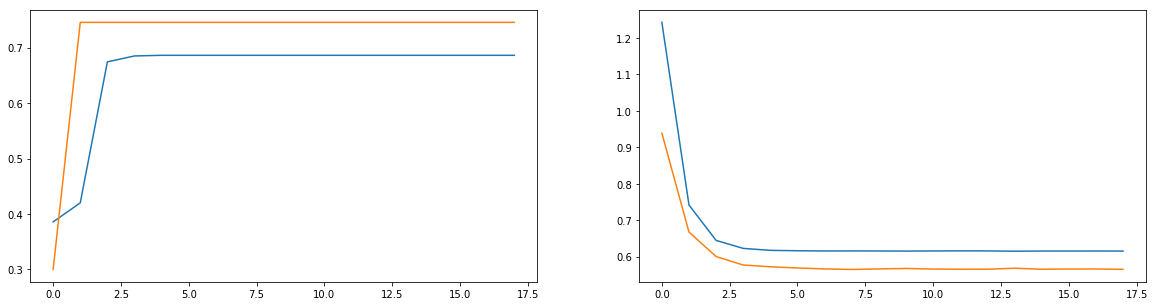

In [18]:
DrawGraphcs(mlp1)

In [19]:
Metrics_NN(mlp1, "mlp_1", test_X, test_Y, window_size)

119/119 [==============================] - 0s 2ms/step
score:  0.5460742489129555
acc:  0.7142857142857143
Precision: 0.8871
Recall: 0.6707
ROC: 0.7408
Training data shape:(845, 1)
Testing data shape:(119, 1)


In [25]:
Save_model(mlp1, "mlp_1")

In [28]:
models = dict()
models["mlp1"] = mlp1

In [29]:
# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
val_X = np.reshape(val_X, (val_X.shape[0], 1, val_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)
print(train_X[0])

New training data shape:
(845, 1, 1)
[[1.]]


In [30]:
def fit_model(X_train, y_train, window_size = 1, X_val = None, y_val = None, val = False):
    model = Sequential()
    
#     model.add(LSTM(1,
#                    bias_initializer='ones',
#                    input_shape = (1, window_size),
#                    return_sequences=True,
#                    name='InputLayer')
#                    )
    
    model.add(LSTM(units=4, return_sequences=True, bias_initializer='ones', input_shape = (1, window_size), name = 'HiddenLayer1'))
    #model.add(Dropout(0.33))
    model.add(LSTM(units=2, return_sequences=True, bias_initializer='ones', name = 'HiddenLayer2'))
    #model.add(Dropout(0.33))
    model.add(LSTM(units=1, activation='softmax', bias_initializer='ones', name='OutputLayer'))
    #model.add(Dense(1))
    model.compile(loss = "binary_crossentropy", 
                  optimizer = "adam", metrics=["accuracy"])
    print(model.summary())
    
    earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
    if val:
            model.fit(X_train, 
              y_train, 
              epochs = 100, 
              batch_size = window_size, 
              verbose = 2,
              validation_data=(X_val, y_val),
              callbacks = [earlystopper])
    else:
        model.fit(X_train, 
                  y_train, 
                  epochs = 100, 
                  batch_size = window_size, 
                  verbose = 1,
                  callbacks = [earlystopper])
    
    return(model)

In [33]:
# Fit the first model.
#model1 = fit_model(train_X, train_Y, window_size)
lstm1 = fit_model(train_X, train_Y, window_size, val_X, val_Y, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
HiddenLayer1 (LSTM)          (None, 1, 4)              96        
_________________________________________________________________
HiddenLayer2 (LSTM)          (None, 1, 2)              56        
_________________________________________________________________
OutputLayer (LSTM)           (None, 1)                 16        
Total params: 168
Trainable params: 168
Non-trainable params: 0
_________________________________________________________________
None
Train on 845 samples, validate on 240 samples
Epoch 1/100
 - 9s - loss: 0.7290 - acc: 0.4308 - val_loss: 0.6679 - val_acc: 0.7458
Epoch 2/100
 - 4s - loss: 0.6506 - acc: 0.6698 - val_loss: 0.6009 - val_acc: 0.7375
Epoch 3/100
 - 4s - loss: 0.6305 - acc: 0.6769 - val_loss: 0.5846 - val_acc: 0.7458
Epoch 4/100
 - 4s - loss: 0.6248 - acc: 0.6864 - val_loss: 0.5781 - val_acc: 0.7458
Epoch 5/100
 - 4s - l

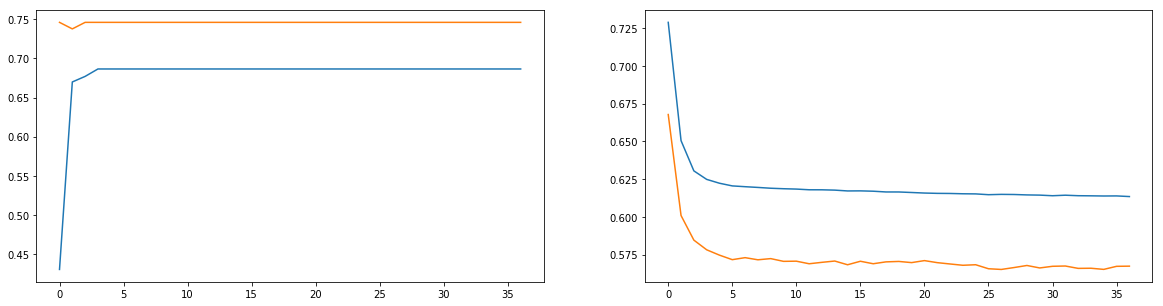

In [34]:
DrawGraphcs(lstm1)

In [35]:
Metrics_NN(lstm1, "lstm_1", test_X, test_Y, window_size)

119/119 [==============================] - 0s 2ms/step
score:  0.5441915418545739
acc:  0.7142857142857143
Precision: 0.8871
Recall: 0.6707
ROC: 0.7408
Training data shape:(845, 1, 1)
Testing data shape:(119, 1, 1)


In [36]:
Save_model(lstm1, "lstm_1")

In [37]:
metrics

{'lr_1': [1,
  (845, 1),
  (119, 1),
  0.7142857142857143,
  0.8870967741935484,
  0.6707317073170732,
  0.7407712590639419],
 'lstm_1': [168,
  (845, 1, 1),
  (119, 1, 1),
  0.7142857142857143,
  0.8870967741935484,
  0.6707317073170732,
  0.7407712590639419],
 'mlp_1': [13,
  (845, 1),
  (119, 1),
  0.7142857142857143,
  0.8870967741935484,
  0.6707317073170732,
  0.7407712590639419]}

### Estudio region central con ventana temporal de 2 quincenas

In [38]:
window_size = 2
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
val_X, val_Y = create_dataset(val, window_size)

In [39]:
Metrics_LR(train_X, train_Y, test_X, test_Y, "lr_2", window_size)

Accuracy of logistic regression classifier on test set: 0.7881
Precision of logistic regression classifier on test set: 0.9000
Recall of logistic regression classifier on test set: 0.7778
Roc of logistic regression classifier on test set: 0.7943
Training data shape:(844, 2)
Testing data shape:(118, 2)


In [40]:
mlp2 = fit_model_mlp(train_X, train_Y, window_size, val_X, val_Y, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense6 (Dense)               (None, 4)                 12        
_________________________________________________________________
DenseOutput (Dense)          (None, 1)                 5         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
None
Train on 844 samples, validate on 239 samples
Epoch 1/100
 - 5s - loss: 0.8814 - acc: 0.3507 - val_loss: 0.7841 - val_acc: 0.3054
Epoch 2/100
 - 1s - loss: 0.7235 - acc: 0.5178 - val_loss: 0.6847 - val_acc: 0.6778
Epoch 3/100
 - 1s - loss: 0.6708 - acc: 0.6363 - val_loss: 0.6454 - val_acc: 0.6778
Epoch 4/100
 - 1s - loss: 0.6467 - acc: 0.6374 - val_loss: 0.6239 - val_acc: 0.6820
Epoch 5/100
 - 1s - loss: 0.6327 - acc: 0.6481 - val_loss: 0.6103 - val_acc: 0.6736
Epoch 6/100
 - 1s - loss: 0.6244 - acc: 0.6552 - val_loss: 0.6008 - val

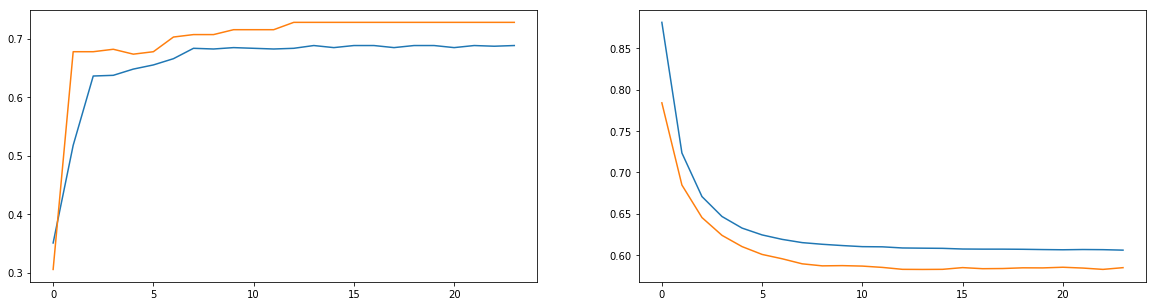

In [41]:
DrawGraphcs(mlp2)

In [42]:
Metrics_NN(mlp2, "mlp_2", test_X, test_Y, window_size)

118/118 [==============================] - 0s 491us/step
score:  0.5011656627816669
acc:  0.788135593220339
Precision: 0.8684
Recall: 0.8148
ROC: 0.7723
Training data shape:(844, 2)
Testing data shape:(118, 2)


In [43]:
Save_model(mlp2, "mlp_2")

In [44]:
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
val_X = np.reshape(val_X, (val_X.shape[0], 1, val_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [45]:
lstm2 = fit_model(train_X, train_Y, window_size, val_X, val_Y, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
HiddenLayer1 (LSTM)          (None, 1, 4)              112       
_________________________________________________________________
HiddenLayer2 (LSTM)          (None, 1, 2)              56        
_________________________________________________________________
OutputLayer (LSTM)           (None, 1)                 16        
Total params: 184
Trainable params: 184
Non-trainable params: 0
_________________________________________________________________
None
Train on 844 samples, validate on 239 samples
Epoch 1/100
 - 6s - loss: 0.7618 - acc: 0.3863 - val_loss: 0.7234 - val_acc: 0.3013
Epoch 2/100
 - 2s - loss: 0.6774 - acc: 0.5924 - val_loss: 0.6528 - val_acc: 0.7155
Epoch 3/100
 - 2s - loss: 0.6499 - acc: 0.6718 - val_loss: 0.6240 - val_acc: 0.7197
Epoch 4/100
 - 2s - loss: 0.6366 - acc: 0.6742 - val_loss: 0.6092 - val_acc: 0.7280
Epoch 5/100
 - 2s - l

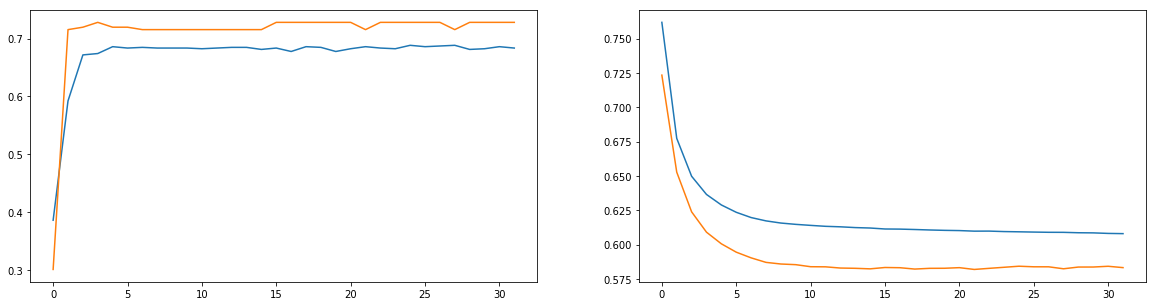

In [46]:
DrawGraphcs(lstm2)

In [47]:
Metrics_NN(lstm2, "lstm_2", test_X, test_Y, window_size)

118/118 [==============================] - 0s 805us/step
score:  0.48972914330029893
acc:  0.788135593220339
Precision: 0.8684
Recall: 0.8148
ROC: 0.7723
Training data shape:(844, 1, 2)
Testing data shape:(118, 1, 2)


In [48]:
Save_model(lstm2, "lstm_2")

In [49]:
metrics

{'lr_1': [1,
  (845, 1),
  (119, 1),
  0.7142857142857143,
  0.8870967741935484,
  0.6707317073170732,
  0.7407712590639419],
 'lr_2': [2,
  (844, 2),
  (118, 2),
  0.788135593220339,
  0.9,
  0.7777777777777778,
  0.7942942942942941],
 'lstm_1': [168,
  (845, 1, 1),
  (119, 1, 1),
  0.7142857142857143,
  0.8870967741935484,
  0.6707317073170732,
  0.7407712590639419],
 'lstm_2': [184,
  (844, 1, 2),
  (118, 1, 2),
  0.788135593220339,
  0.868421052631579,
  0.8148148148148148,
  0.7722722722722722],
 'mlp_1': [13,
  (845, 1),
  (119, 1),
  0.7142857142857143,
  0.8870967741935484,
  0.6707317073170732,
  0.7407712590639419],
 'mlp_2': [17,
  (844, 2),
  (118, 2),
  0.788135593220339,
  0.868421052631579,
  0.8148148148148148,
  0.7722722722722722]}

### Estudio region central con ventana temporal de 3 quincenas

In [50]:
window_size = 3
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
val_X, val_Y = create_dataset(val, window_size)



In [51]:
Metrics_LR(train_X, train_Y, test_X, test_Y, "lr_3", window_size)

Accuracy of logistic regression classifier on test set: 0.7778
Precision of logistic regression classifier on test set: 0.8857
Recall of logistic regression classifier on test set: 0.7750
Roc of logistic regression classifier on test set: 0.7794
Training data shape:(843, 3)
Testing data shape:(117, 3)


In [52]:
mlp3 = fit_model_mlp(train_X, train_Y, window_size, val_X, val_Y, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense6 (Dense)               (None, 4)                 16        
_________________________________________________________________
DenseOutput (Dense)          (None, 1)                 5         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
None
Train on 843 samples, validate on 238 samples
Epoch 1/100
 - 2s - loss: 0.8946 - acc: 0.3867 - val_loss: 0.8076 - val_acc: 0.3025
Epoch 2/100
 - 0s - loss: 0.7003 - acc: 0.5065 - val_loss: 0.6631 - val_acc: 0.7269
Epoch 3/100
 - 0s - loss: 0.6397 - acc: 0.6821 - val_loss: 0.6130 - val_acc: 0.7311
Epoch 4/100
 - 0s - loss: 0.6206 - acc: 0.6833 - val_loss: 0.5932 - val_acc: 0.7227
Epoch 5/100
 - 0s - loss: 0.6128 - acc: 0.6785 - val_loss: 0.5853 - val_acc: 0.7311
Epoch 6/100
 - 0s - loss: 0.6089 - acc: 0.6868 - val_loss: 0.5804 - val

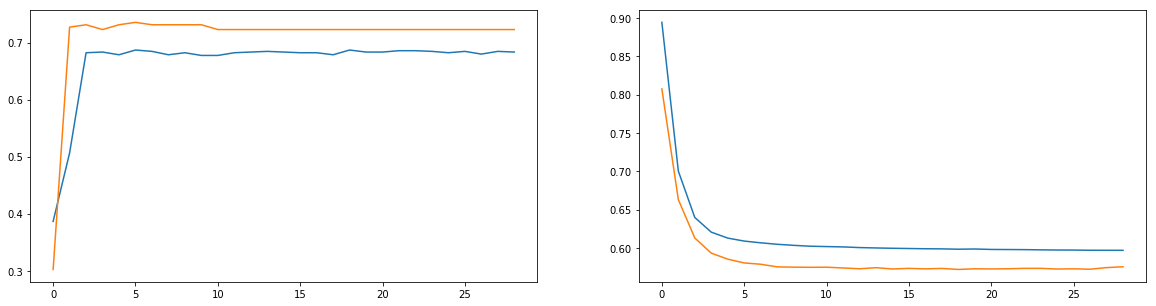

In [53]:
DrawGraphcs(mlp3)

In [54]:
Metrics_NN(mlp3, "mlp_3", test_X, test_Y, window_size)

117/117 [==============================] - 0s 344us/step
score:  0.45462463729274577
acc:  0.8376068442295759
Precision: 0.8675
Recall: 0.9000
ROC: 0.8014
Training data shape:(843, 3)
Testing data shape:(117, 3)


In [55]:
Save_model(mlp3, "mlp_3")

In [56]:
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
val_X = np.reshape(val_X, (val_X.shape[0], 1, val_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [57]:
lstm3 = fit_model(train_X, train_Y, window_size, val_X, val_Y, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
HiddenLayer1 (LSTM)          (None, 1, 4)              128       
_________________________________________________________________
HiddenLayer2 (LSTM)          (None, 1, 2)              56        
_________________________________________________________________
OutputLayer (LSTM)           (None, 1)                 16        
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________
None
Train on 843 samples, validate on 238 samples
Epoch 1/100
 - 6s - loss: 0.7649 - acc: 0.3867 - val_loss: 0.7535 - val_acc: 0.3025
Epoch 2/100
 - 2s - loss: 0.7017 - acc: 0.4472 - val_loss: 0.6767 - val_acc: 0.7185
Epoch 3/100
 - 1s - loss: 0.6636 - acc: 0.6643 - val_loss: 0.6344 - val_acc: 0.7227
Epoch 4/100
 - 2s - loss: 0.6437 - acc: 0.6631 - val_loss: 0.6125 - val_acc: 0.7143
Epoch 5/100
 - 1s - l

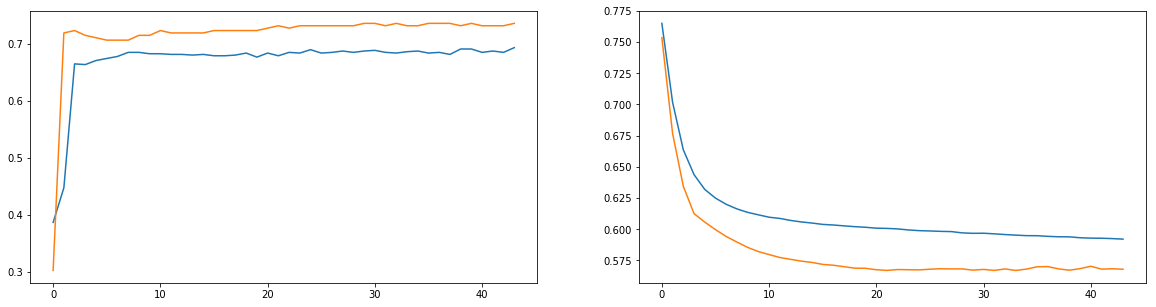

In [58]:
DrawGraphcs(lstm3)

In [59]:
Metrics_NN(lstm3, "lstm_3", test_X, test_Y, window_size)

117/117 [==============================] - 0s 627us/step
score:  0.46517850152957135
acc:  0.8290598354278467
Precision: 0.8659
Recall: 0.8875
ROC: 0.7951
Training data shape:(843, 1, 3)
Testing data shape:(117, 1, 3)


In [60]:
Save_model(lstm3, "lstm_3")

In [61]:
metrics

{'lr_1': [1,
  (845, 1),
  (119, 1),
  0.7142857142857143,
  0.8870967741935484,
  0.6707317073170732,
  0.7407712590639419],
 'lr_2': [2,
  (844, 2),
  (118, 2),
  0.788135593220339,
  0.9,
  0.7777777777777778,
  0.7942942942942941],
 'lr_3': [3,
  (843, 3),
  (117, 3),
  0.7777777777777778,
  0.8857142857142857,
  0.775,
  0.7793918918918918],
 'lstm_1': [168,
  (845, 1, 1),
  (119, 1, 1),
  0.7142857142857143,
  0.8870967741935484,
  0.6707317073170732,
  0.7407712590639419],
 'lstm_2': [184,
  (844, 1, 2),
  (118, 1, 2),
  0.788135593220339,
  0.868421052631579,
  0.8148148148148148,
  0.7722722722722722],
 'lstm_3': [200,
  (843, 1, 3),
  (117, 1, 3),
  0.8290598354278467,
  0.8658536585365854,
  0.8875,
  0.7951013513513513],
 'mlp_1': [13,
  (845, 1),
  (119, 1),
  0.7142857142857143,
  0.8870967741935484,
  0.6707317073170732,
  0.7407712590639419],
 'mlp_2': [17,
  (844, 2),
  (118, 2),
  0.788135593220339,
  0.868421052631579,
  0.8148148148148148,
  0.7722722722722722],
 'm

### Estudio region central con ventana temporal de 4 quincenas


In [62]:
window_size = 4
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
val_X, val_Y = create_dataset(val, window_size)

In [63]:
Metrics_LR(train_X, train_Y, test_X, test_Y, "lr_4", window_size)

Accuracy of logistic regression classifier on test set: 0.8103
Precision of logistic regression classifier on test set: 0.8701
Recall of logistic regression classifier on test set: 0.8481
Roc of logistic regression classifier on test set: 0.7889
Training data shape:(842, 4)
Testing data shape:(116, 4)


In [64]:
mlp4 = fit_model_mlp(train_X, train_Y, window_size, val_X, val_Y, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense6 (Dense)               (None, 4)                 20        
_________________________________________________________________
DenseOutput (Dense)          (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
None
Train on 842 samples, validate on 237 samples
Epoch 1/100
 - 2s - loss: 0.9666 - acc: 0.3670 - val_loss: 0.9393 - val_acc: 0.3038
Epoch 2/100
 - 0s - loss: 0.8110 - acc: 0.3682 - val_loss: 0.7867 - val_acc: 0.3586
Epoch 3/100
 - 0s - loss: 0.7352 - acc: 0.4264 - val_loss: 0.7027 - val_acc: 0.4388
Epoch 4/100
 - 0s - loss: 0.6980 - acc: 0.5368 - val_loss: 0.6605 - val_acc: 0.7426
Epoch 5/100
 - 0s - loss: 0.6772 - acc: 0.6496 - val_loss: 0.6337 - val_acc: 0.7426
Epoch 6/100
 - 0s - loss: 0.6599 - acc: 0.6580 - val_loss: 0.6146 - val

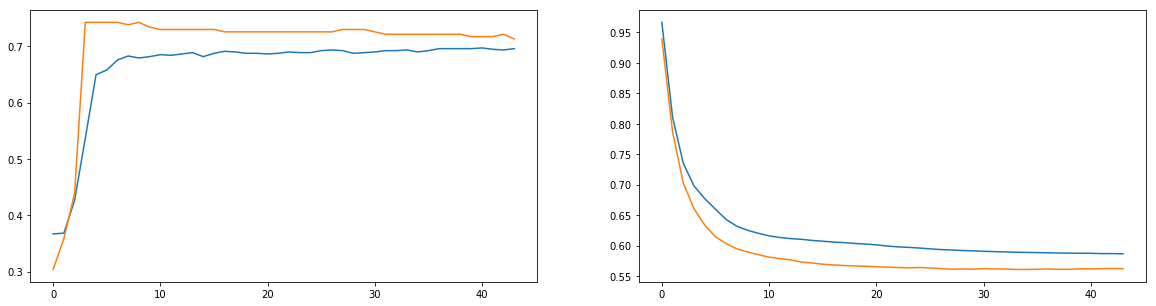

In [65]:
DrawGraphcs(mlp4)

In [66]:
Metrics_NN(mlp4, "mlp_4", test_X, test_Y, window_size)

116/116 [==============================] - 0s 192us/step
score:  0.4444407245208477
acc:  0.8448275862068966
Precision: 0.8765
Recall: 0.8987
ROC: 0.8142
Training data shape:(842, 4)
Testing data shape:(116, 4)


In [67]:
Save_model(mlp4, "mlp_4")

In [68]:
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
val_X = np.reshape(val_X, (val_X.shape[0], 1, val_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [69]:
lstm4 = fit_model(train_X, train_Y, window_size, val_X, val_Y, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
HiddenLayer1 (LSTM)          (None, 1, 4)              144       
_________________________________________________________________
HiddenLayer2 (LSTM)          (None, 1, 2)              56        
_________________________________________________________________
OutputLayer (LSTM)           (None, 1)                 16        
Total params: 216
Trainable params: 216
Non-trainable params: 0
_________________________________________________________________
None
Train on 842 samples, validate on 237 samples
Epoch 1/100
 - 6s - loss: 0.8670 - acc: 0.3872 - val_loss: 0.8574 - val_acc: 0.2996
Epoch 2/100
 - 1s - loss: 0.7621 - acc: 0.3872 - val_loss: 0.7504 - val_acc: 0.2996
Epoch 3/100
 - 1s - loss: 0.6993 - acc: 0.4430 - val_loss: 0.6813 - val_acc: 0.7173
Epoch 4/100
 - 1s - loss: 0.6664 - acc: 0.6627 - val_loss: 0.6457 - val_acc: 0.7173
Epoch 5/100
 - 1s - l

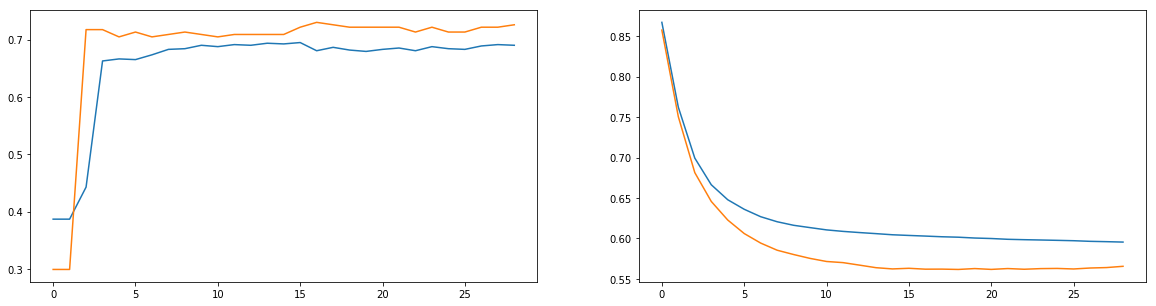

In [70]:
DrawGraphcs(lstm4)

In [71]:
Metrics_NN(lstm4, "lstm_4", test_X, test_Y, window_size)

116/116 [==============================] - 0s 546us/step
score:  0.4498101318704671
acc:  0.8620689655172413
Precision: 0.8706
Recall: 0.9367
ROC: 0.8197
Training data shape:(842, 1, 4)
Testing data shape:(116, 1, 4)


In [72]:
Save_model(lstm4, "lstm_4")

In [73]:
metrics

{'lr_1': [1,
  (845, 1),
  (119, 1),
  0.7142857142857143,
  0.8870967741935484,
  0.6707317073170732,
  0.7407712590639419],
 'lr_2': [2,
  (844, 2),
  (118, 2),
  0.788135593220339,
  0.9,
  0.7777777777777778,
  0.7942942942942941],
 'lr_3': [3,
  (843, 3),
  (117, 3),
  0.7777777777777778,
  0.8857142857142857,
  0.775,
  0.7793918918918918],
 'lr_4': [4,
  (842, 4),
  (116, 4),
  0.8103448275862069,
  0.8701298701298701,
  0.8481012658227848,
  0.7889154977762572],
 'lstm_1': [168,
  (845, 1, 1),
  (119, 1, 1),
  0.7142857142857143,
  0.8870967741935484,
  0.6707317073170732,
  0.7407712590639419],
 'lstm_2': [184,
  (844, 1, 2),
  (118, 1, 2),
  0.788135593220339,
  0.868421052631579,
  0.8148148148148148,
  0.7722722722722722],
 'lstm_3': [200,
  (843, 1, 3),
  (117, 1, 3),
  0.8290598354278467,
  0.8658536585365854,
  0.8875,
  0.7951013513513513],
 'lstm_4': [216,
  (842, 1, 4),
  (116, 1, 4),
  0.8620689655172413,
  0.8705882352941177,
  0.9367088607594937,
  0.81970578173109

## Modelo espacio-temporal

### Estudio region central con ventana temporal de 1 quicena, incluyendo en el dataset las regiones adyacentes

In [74]:
region_total = vectors2
train_size = int(len(region_total) * 0.7)
train9 = region_total[0:train_size]
test_size = int(len(region_total) * 0.1) + train_size
test9 = region_total[train_size:test_size]
val9 = region_total[test_size:len(region_total)]

In [75]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset.values[i:i + window_size,:]
        data_X.append(a)
        data_Y.append(dataset.iloc[i + window_size,4])
    X = np.array(data_X)
    Y = np.array(data_Y)
    Y[Y>1] = 1
    return X,Y

In [76]:
def Metrics_LR_9(train_X, train_Y, test_X, test_Y, name, window_size):
    lr_train_X, lr_train_Y = train_X, train_Y
    lr_test_X, lr_test_Y = test_X, test_Y
    
    lr_train_X9 = np.reshape(train_X, (train_X.shape[0], train_X.shape[1] * 9))
    lr_train_Y9 = train_Y
    lr_test_X9 = np.reshape(test_X, (test_X.shape[0], test_X.shape[1] * 9))
    lr_test_Y9 = test_Y

    clf = LogisticRegression()
    clf.fit(lr_train_X9, lr_train_Y9)

    lr_y_pred = clf.predict(lr_test_X9)

    acc = clf.score(lr_test_X9, lr_test_Y9)
    print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(acc))
    precision = precision_score(lr_test_Y9, lr_y_pred)
    print('Precision of logistic regression classifier on test set: {:.4f}'.format(precision))
    recall = recall_score(lr_test_Y9, lr_y_pred)
    print('Recall of logistic regression classifier on test set: {:.4f}'.format(recall))
    roc = roc_auc_score(lr_test_Y9, lr_y_pred)
    print('Roc of logistic regression classifier on test set: {:.4f}'.format(roc))
    print('Training data shape:{}'.format(train_X.shape))
    print('Testing data shape:{}'.format(test_X.shape))
    metrics[name] = [window_size, train_X.shape, test_X.shape, acc, precision, recall, roc]

In [77]:
def Metrics_NN_9(model, model_name, trainX, trainY, testX, testY, window_size):
    y_pred = model.predict(testX).round()
    score, acc = model.evaluate(testX, testY, batch_size=window_size)
    print('score: ', score)
    print('acc: ', acc)
    precision = precision_score(testY, y_pred)
    print('Precision: {:.4f}'.format(precision))
    recall = recall_score(testY, y_pred)
    print('Recall: {:.4f}'.format(recall))
    roc = roc_auc_score(testY, y_pred)
    print('ROC: {:.4f}'.format(roc))
    print('Training data shape:{}'.format(trainX.shape))
    print('Testing data shape:{}'.format(testX.shape))
    metrics[model_name] = [model.count_params(), trainX.shape, testX.shape, acc, precision, recall, roc]

In [78]:
def Reshape_Tensor_9(data_train, data_test, data_val, isMlp = True):
    
    if isMlp:
        data_train = np.reshape(data_train, (data_train.shape[0], data_train.shape[1] * data_train.shape[2]))
        data_test = np.reshape(data_test, (data_test.shape[0], data_test.shape[1] * data_test.shape[2])) 
        data_val = np.reshape(data_val, (data_val.shape[0], data_val.shape[1] *  data_val.shape[2]))
    else:        
        data_train = np.reshape(data_train, (data_train.shape[0], 1, data_train.shape[1] * data_train.shape[2]))
        data_test = np.reshape(data_test, (data_test.shape[0], 1, data_test.shape[1] * data_test.shape[2])) 
        data_val = np.reshape(data_val, (data_val.shape[0], 1, data_val.shape[1] *  data_val.shape[2]))
    return data_train, data_test, data_val

In [79]:
def fit_model_mlp_9 (X_train, y_train, window_size = 1, X_val = None, y_val = None, val = False):
    model = Sequential()
    model.add(Dense(4, bias_initializer='ones', input_dim=window_size*9, activation='tanh', name = 'Dense6'))
    model.add(Dense(1, bias_initializer = 'ones', activation='sigmoid', name = 'DenseOutput'))
    model.compile(loss = "binary_crossentropy", 
                  optimizer = "adam", metrics=["accuracy"])
    
    print(model.summary())
    
    earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    
    if val:
            model.fit(X_train, 
              y_train, 
              epochs = 100, 
              batch_size = window_size, 
              verbose = 2,
              validation_data=(X_val, y_val),
              callbacks = [earlystopper])
    else:
        model.fit(X_train, 
                  y_train, 
                  epochs = 100, 
                  batch_size = window_size, 
                  verbose = 1,
                  callbacks = [earlystopper])
    
    #print(model.summary())
    return(model)

In [80]:
def fit_model(X_train, y_train, window_size = 1, X_val = None, y_val = None, val = False):
    model = Sequential()
    
#     model.add(LSTM(1,
#                    bias_initializer='ones',
#                    input_shape = (1, window_size * 9),
#                    return_sequences=True,
#                    name='InputLayer')
#                    )
    model.add(LSTM(units=4, return_sequences=True, bias_initializer='ones', input_shape = (1, window_size * 9),
                   name = 'HiddenLayer1'))
    model.add(Dropout(0.5))
    model.add(LSTM(units=3, return_sequences=True, bias_initializer='ones', name = 'HiddenLayer2'))
    model.add(Dropout(0.4))
    model.add(LSTM(units=1, activation='softmax', bias_initializer = 'ones', name='OutputLayer'))
    model.compile(loss = "binary_crossentropy", 
                  optimizer = "adam", metrics=["accuracy"])
    print(model.summary())
    
    earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    if val:
            model.fit(X_train, 
              y_train, 
              epochs = 200, 
              batch_size = window_size, 
              verbose = 2,
              validation_data=(X_val, y_val),
              callbacks=[earlystopper])
    else:
        model.fit(X_train, 
                  y_train, 
                  epochs = 200, 
                  batch_size = window_size, 
                  verbose = 1,
                  callbacks=[earlystopper])
    
    return(model)

In [81]:
# Create test and training sets for one-step-ahead regression.
window_size_sp = 1
otrain_X9, otrain_Y9 = create_dataset(train9, window_size_sp)
otest_X9, otest_Y9 = create_dataset(test9, window_size_sp)
oval_X9, oval_Y9 = create_dataset(val9, window_size_sp)

In [82]:
Metrics_LR_9(otrain_X9, otrain_Y9, otest_X9, otest_Y9, "lr_1_9", window_size_sp)

Accuracy of logistic regression classifier on test set: 0.8151
Precision of logistic regression classifier on test set: 0.8750
Recall of logistic regression classifier on test set: 0.8537
Roc of logistic regression classifier on test set: 0.7917
Training data shape:(845, 1, 9)
Testing data shape:(119, 1, 9)


In [83]:
mtrain_X9, mtest_X9, mval_X9 = Reshape_Tensor_9(otrain_X9, otest_X9, oval_X9)

In [84]:
mlp1_9 = fit_model_mlp_9(mtrain_X9, otrain_Y9, window_size_sp, mval_X9, oval_Y9, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense6 (Dense)               (None, 4)                 40        
_________________________________________________________________
DenseOutput (Dense)          (None, 1)                 5         
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________
None
Train on 845 samples, validate on 240 samples
Epoch 1/100
 - 4s - loss: 1.0216 - acc: 0.4024 - val_loss: 0.8104 - val_acc: 0.3458
Epoch 2/100
 - 1s - loss: 0.7026 - acc: 0.5160 - val_loss: 0.6340 - val_acc: 0.7417
Epoch 3/100
 - 1s - loss: 0.6462 - acc: 0.6686 - val_loss: 0.5998 - val_acc: 0.7375
Epoch 4/100
 - 1s - loss: 0.6303 - acc: 0.6734 - val_loss: 0.5860 - val_acc: 0.7375
Epoch 5/100
 - 1s - loss: 0.6226 - acc: 0.6817 - val_loss: 0.5810 - val_acc: 0.7333
Epoch 6/100
 - 1s - loss: 0.6180 - acc: 0.6805 - val_loss: 0.5774 - val

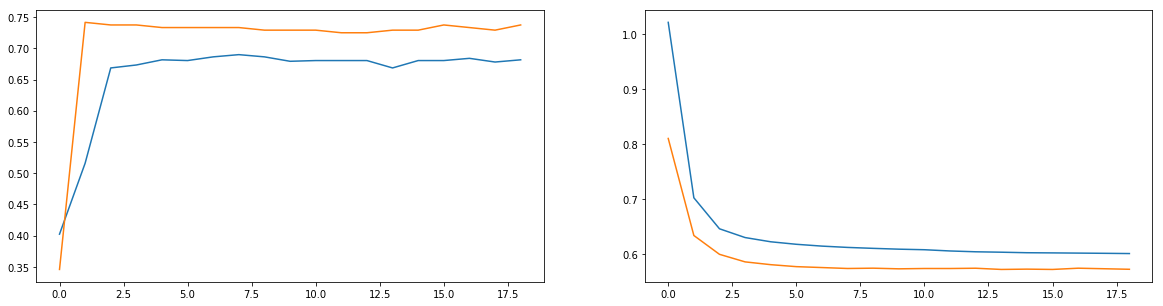

In [85]:
DrawGraphcs(mlp1_9)

In [86]:
Metrics_NN_9(mlp1_9, "mlp_1_9", mtrain_X9, otrain_Y9,mtest_X9, otest_Y9, window_size_sp)

119/119 [==============================] - 0s 926us/step
score:  0.4548641333998251
acc:  0.8235294117647058
Precision: 0.8765
Recall: 0.8659
ROC: 0.7978
Training data shape:(845, 9)
Testing data shape:(119, 9)


In [87]:
Save_model(mlp1_9, "mlp_1_9")

In [88]:
ltrain_X9, ltest_X9, lval_X9 = Reshape_Tensor_9(otrain_X9, otest_X9, oval_X9, False)

In [89]:
lstm_1_9 = fit_model(ltrain_X9, otrain_Y9, window_size_sp, lval_X9, oval_Y9, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
HiddenLayer1 (LSTM)          (None, 1, 4)              224       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 4)              0         
_________________________________________________________________
HiddenLayer2 (LSTM)          (None, 1, 3)              96        
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 3)              0         
_________________________________________________________________
OutputLayer (LSTM)           (None, 1)                 20        
Total params: 340
Trainable params: 340
Non-trainable params: 0
_________________________________________________________________
None
Train on 845 samples, validate on 240 samples
Epoch 1/200
 - 10s - loss: 0.8233 - acc: 0.3858 - val_loss: 0.7544 - val_acc: 0.3000
Epoch 2/

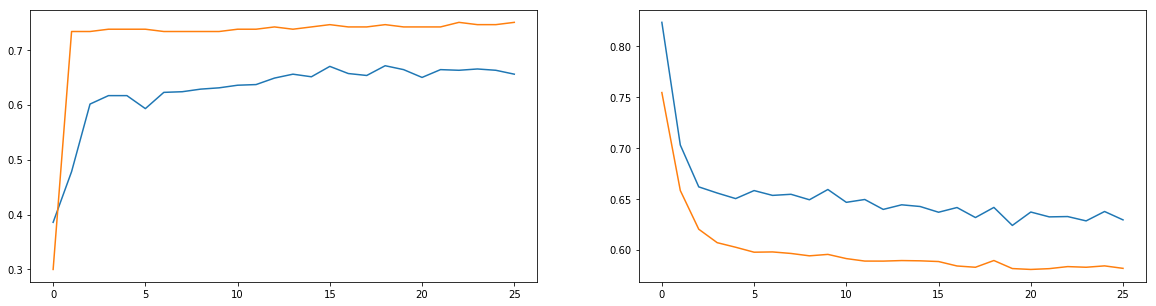

In [90]:
DrawGraphcs(lstm_1_9)

In [91]:
Metrics_NN_9(lstm_1_9, "lstm_1_9", ltrain_X9, otrain_Y9, ltest_X9, otest_Y9, window_size_sp)

119/119 [==============================] - 0s 2ms/step
score:  0.55879591167474
acc:  0.8067226890756303
Precision: 0.8933
Recall: 0.8171
ROC: 0.8004
Training data shape:(845, 1, 9)
Testing data shape:(119, 1, 9)


In [92]:
Save_model(lstm_1_9, "lstm_1_9")

### Estudio region central con ventana temporal de 2 quicena, incluyendo en el dataset las regiones adyacentes

In [93]:
# Create test and training sets for one-step-ahead regression.
window_size_sp = 2
otrain_X9, otrain_Y9 = create_dataset(train9, window_size_sp)
otest_X9, otest_Y9 = create_dataset(test9, window_size_sp)
oval_X9, oval_Y9 = create_dataset(val9, window_size_sp)

In [94]:
Metrics_LR_9(otrain_X9, otrain_Y9, otest_X9, otest_Y9, "lr_2_9", window_size_sp)

Accuracy of logistic regression classifier on test set: 0.8390
Precision of logistic regression classifier on test set: 0.8875
Recall of logistic regression classifier on test set: 0.8765
Roc of logistic regression classifier on test set: 0.8166
Training data shape:(844, 2, 9)
Testing data shape:(118, 2, 9)


In [95]:
mtrain_X9, mtest_X9, mval_X9 = Reshape_Tensor_9(otrain_X9, otest_X9, oval_X9)

In [96]:
mlp2_9 = fit_model_mlp_9(mtrain_X9, otrain_Y9, window_size_sp, mval_X9, oval_Y9, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense6 (Dense)               (None, 4)                 76        
_________________________________________________________________
DenseOutput (Dense)          (None, 1)                 5         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
None
Train on 844 samples, validate on 239 samples
Epoch 1/100
 - 3s - loss: 0.8869 - acc: 0.3945 - val_loss: 0.7265 - val_acc: 0.3724
Epoch 2/100
 - 1s - loss: 0.6739 - acc: 0.5794 - val_loss: 0.6208 - val_acc: 0.7280
Epoch 3/100
 - 1s - loss: 0.6395 - acc: 0.6564 - val_loss: 0.5975 - val_acc: 0.7322
Epoch 4/100
 - 1s - loss: 0.6230 - acc: 0.6659 - val_loss: 0.5876 - val_acc: 0.7238
Epoch 5/100
 - 1s - loss: 0.6130 - acc: 0.6789 - val_loss: 0.5814 - val_acc: 0.7238
Epoch 6/100
 - 1s - loss: 0.6072 - acc: 0.6836 - val_loss: 0.5826 - val

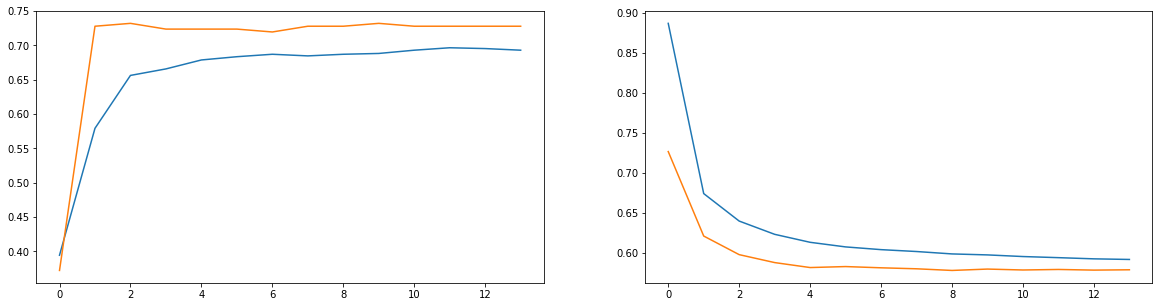

In [97]:
DrawGraphcs(mlp2_9)

In [98]:
Metrics_NN_9(mlp2_9, "mlp_2_9", mtrain_X9, otrain_Y9, mtest_X9, otest_Y9, window_size_sp)

118/118 [==============================] - 0s 492us/step
score:  0.4442829403836848
acc:  0.8220338983050848
Precision: 0.8750
Recall: 0.8642
ROC: 0.7970
Training data shape:(844, 18)
Testing data shape:(118, 18)


In [99]:
Save_model(mlp2_9, "mlp_2_9")

In [100]:
ltrain_X9, ltest_X9, lval_X9 = Reshape_Tensor_9(otrain_X9, otest_X9, oval_X9, False)

In [101]:
lstm_2_9 = fit_model(ltrain_X9, otrain_Y9, window_size_sp, lval_X9, oval_Y9, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
HiddenLayer1 (LSTM)          (None, 1, 4)              368       
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 4)              0         
_________________________________________________________________
HiddenLayer2 (LSTM)          (None, 1, 3)              96        
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 3)              0         
_________________________________________________________________
OutputLayer (LSTM)           (None, 1)                 20        
Total params: 484
Trainable params: 484
Non-trainable params: 0
_________________________________________________________________
None
Train on 844 samples, validate on 239 samples
Epoch 1/200
 - 9s - loss: 0.7796 - acc: 0.3969 - val_loss: 0.7475 - val_acc: 0.3013
Epoch 2/2

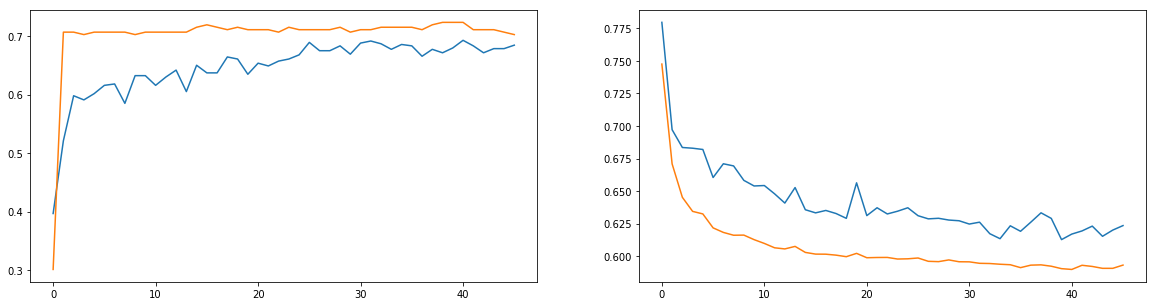

In [106]:
DrawGraphcs(lstm_2_9)

In [107]:
Metrics_NN_9(lstm_2_9, "lstm_2_9", ltrain_X9, otrain_Y9, ltest_X9, otest_Y9, window_size_sp)

118/118 [==============================] - 0s 907us/step
score:  0.5100252971810809
acc:  0.8220338983050848
Precision: 0.8659
Recall: 0.8765
ROC: 0.7896
Training data shape:(844, 1, 18)
Testing data shape:(118, 1, 18)


In [108]:
Save_model(lstm_2_9, "lstm_2_9")

### Estudio region central con ventana temporal de 3 quicenas, incluyendo en el dataset las regiones adyacentes

In [109]:
# Create test and training sets for one-step-ahead regression.
window_size_sp = 3
otrain_X9, otrain_Y9 = create_dataset(train9, window_size_sp)
otest_X9, otest_Y9 = create_dataset(test9, window_size_sp)
oval_X9, oval_Y9 = create_dataset(val9, window_size_sp)

In [110]:
Metrics_LR_9(otrain_X9, otrain_Y9, otest_X9, otest_Y9, "lr_3_9", window_size_sp)

Accuracy of logistic regression classifier on test set: 0.8376
Precision of logistic regression classifier on test set: 0.8675
Recall of logistic regression classifier on test set: 0.9000
Roc of logistic regression classifier on test set: 0.8014
Training data shape:(843, 3, 9)
Testing data shape:(117, 3, 9)


In [111]:
mtrain_X9, mtest_X9, mval_X9 = Reshape_Tensor_9(otrain_X9, otest_X9, oval_X9)

In [116]:
mlp3_9 = fit_model_mlp_9(mtrain_X9, otrain_Y9, window_size_sp, mval_X9, oval_Y9, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense6 (Dense)               (None, 4)                 112       
_________________________________________________________________
DenseOutput (Dense)          (None, 1)                 5         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________
None
Train on 843 samples, validate on 238 samples
Epoch 1/100
 - 4s - loss: 1.1883 - acc: 0.3689 - val_loss: 1.0536 - val_acc: 0.2983
Epoch 2/100
 - 1s - loss: 0.8631 - acc: 0.3642 - val_loss: 0.7954 - val_acc: 0.3613
Epoch 3/100
 - 0s - loss: 0.7591 - acc: 0.4199 - val_loss: 0.6990 - val_acc: 0.5126
Epoch 4/100
 - 1s - loss: 0.7169 - acc: 0.4840 - val_loss: 0.6556 - val_acc: 0.6597
Epoch 5/100
 - 0s - loss: 0.6947 - acc: 0.5469 - val_loss: 0.6342 - val_acc: 0.6975
Epoch 6/100
 - 1s - loss: 0.6778 - acc: 0.6074 - val_loss: 0.6198 - v

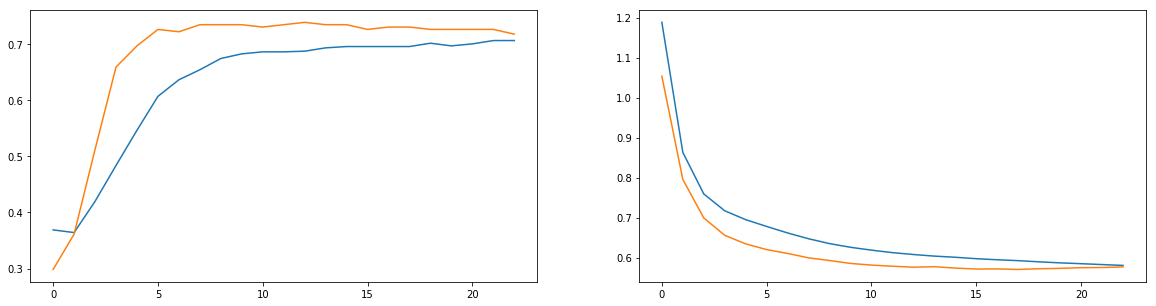

In [117]:
DrawGraphcs(mlp3_9)

In [118]:
Metrics_NN_9(mlp3_9, "mlp_3_9", mtrain_X9, otrain_Y9, mtest_X9, otest_Y9, window_size_sp)

117/117 [==============================] - 0s 296us/step
score:  0.4596449748063699
acc:  0.8717948786723309
Precision: 0.8736
Recall: 0.9500
ROC: 0.8264
Training data shape:(843, 27)
Testing data shape:(117, 27)


In [119]:
Save_model(mlp3_9, "mlp_3_9")

In [120]:
ltrain_X9, ltest_X9, lval_X9 = Reshape_Tensor_9(otrain_X9, otest_X9, oval_X9, False)

In [124]:
lstm_3_9 = fit_model(ltrain_X9, otrain_Y9, window_size_sp, lval_X9, oval_Y9, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
HiddenLayer1 (LSTM)          (None, 1, 4)              512       
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 4)              0         
_________________________________________________________________
HiddenLayer2 (LSTM)          (None, 1, 3)              96        
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 3)              0         
_________________________________________________________________
OutputLayer (LSTM)           (None, 1)                 20        
Total params: 628
Trainable params: 628
Non-trainable params: 0
_________________________________________________________________
None
Train on 843 samples, validate on 238 samples
Epoch 1/200
 - 8s - loss: 0.7159 - acc: 0.4899 - val_loss: 0.6887 - val_acc: 0.6471
Epoch 2/2

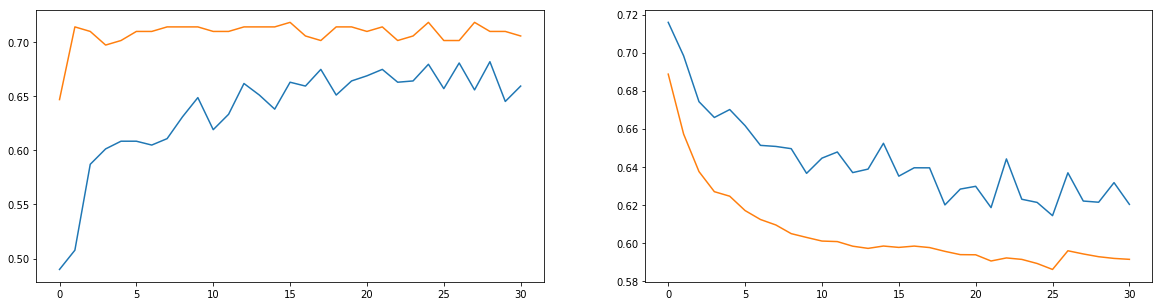

In [125]:
DrawGraphcs(lstm_3_9)

In [126]:
Metrics_NN_9(lstm_3_9, "lstm_3_9", ltrain_X9, otrain_Y9, ltest_X9, otest_Y9, window_size_sp)

117/117 [==============================] - 0s 708us/step
score:  0.5150165359179179
acc:  0.8461538537954673
Precision: 0.8690
Recall: 0.9125
ROC: 0.8076
Training data shape:(843, 1, 27)
Testing data shape:(117, 1, 27)


In [127]:
Save_model(lstm_3_9, "lstm_3_9")

## Carga de modelos e histories

In [120]:
def LoadHistoryFromJSON(filename):
    dic = dict()
    with open(filename, "r") as json_file:
        dic = json.load(json_file)
    return dic

In [121]:
model_names = ["mlp_1", "lstm_1","mlp_2", "lstm_2","mlp_3", "lstm_3", "mlp_4", "lstm_4","mlp_1_9", "lstm_1_9","mlp_2_9", "lstm_2_9","mlp_3_9", "lstm_3_9"]

histories = {}
for model_name in model_names:
    name = model_name+'_20190911_history.json'
    histories[model_name] = LoadHistoryFromJSON(name)

## Comparativa de las métricas de todos los modelos

In [123]:
# data = pd.DataFrame.from_dict(metrics, orient='index')
# data.columns = ['nparams', 'train_shape', 'test_shape','acc','precision','recall','roc_auc']
# data['name'] = data.index.values
# data

In [131]:
# data.to_csv('Metricas.csv')

In [124]:
data = pd.read_csv('Metricas.csv', index_col=0)

In [125]:
def GraficoBarrasH(serie, title):
    bar_colors = ['yellowgreen', 'olivedrab','darkolivegreen'] * 1000
    ax = serie.plot(kind='barh', figsize=(12,6), color=bar_colors, fontsize=13, title=title)
           
    # set individual bar lables using above list
    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(i.get_width()+.005, i.get_y()+0.5, \
              str(round((i.get_width()), 3)), fontsize=10, color='black')
    
    # invert for largest on top 
    ax.invert_yaxis()

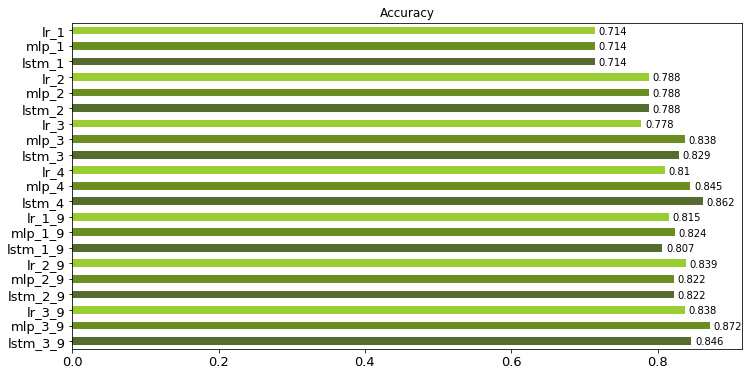

In [126]:
GraficoBarrasH(data['acc'],'Accuracy')

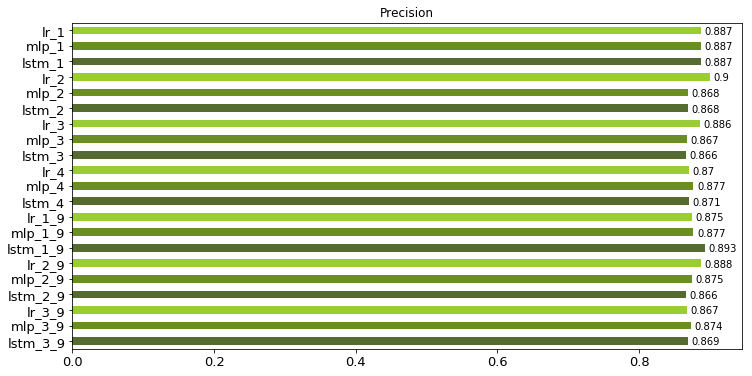

In [127]:
GraficoBarrasH(data['precision'], 'Precision')

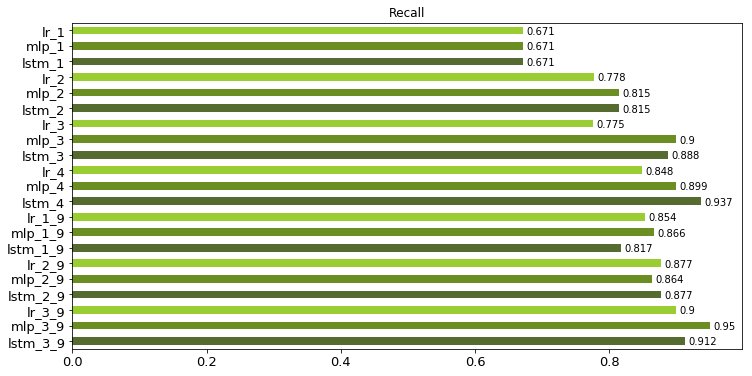

In [128]:
GraficoBarrasH(data['recall'], 'Recall')

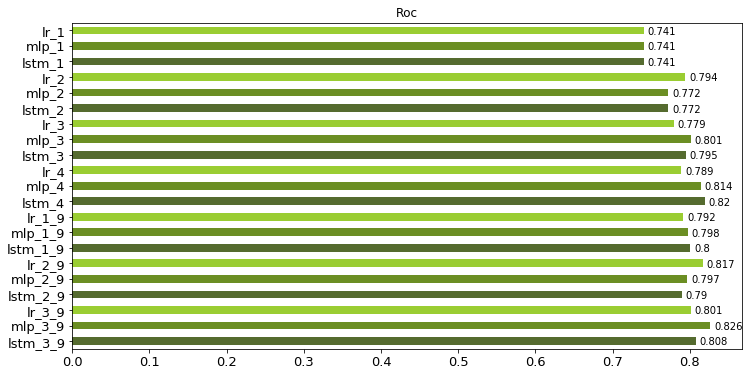

In [129]:
GraficoBarrasH(data['roc_auc'], 'Roc')

## Comparativa de los modelos LSTM

In [166]:
def DrawValLossFromHistories(histories, representacion):
    plt.figure(figsize=(20,8))
    legend1, legend2, legend3, legend4 = [], [], [], []

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    for key in histories.keys():
        if "_1" in key:
            plt.subplot(221)
            plt.plot(histories[key][representacion])
            legend1.append(key)
            plt.legend(legend1)
            plt.title('Modelos con ventana $\it{m}$=1')

        if "_2" in key:
            plt.subplot(222)
            plt.plot(histories[key][representacion])
            legend2.append(key)
            plt.legend(legend2)
            plt.title('Modelos con ventana $\it{m}$=2')

        if "_3" in key:
            plt.subplot(223)
            plt.plot(histories[key][representacion])
            legend3.append(key)
            plt.legend(legend3)
            plt.title('Modelos con ventana $\it{m}$=3')

        if "_4" in key:
            plt.subplot(224)
            plt.plot(histories[key][representacion])
            legend4.append(key)
            plt.legend(legend4)
            plt.title('Modelos con ventana $\it{m}$=4')

        plt.xlabel('epochs')
        plt.ylabel(representacion)
        plt.grid(True)

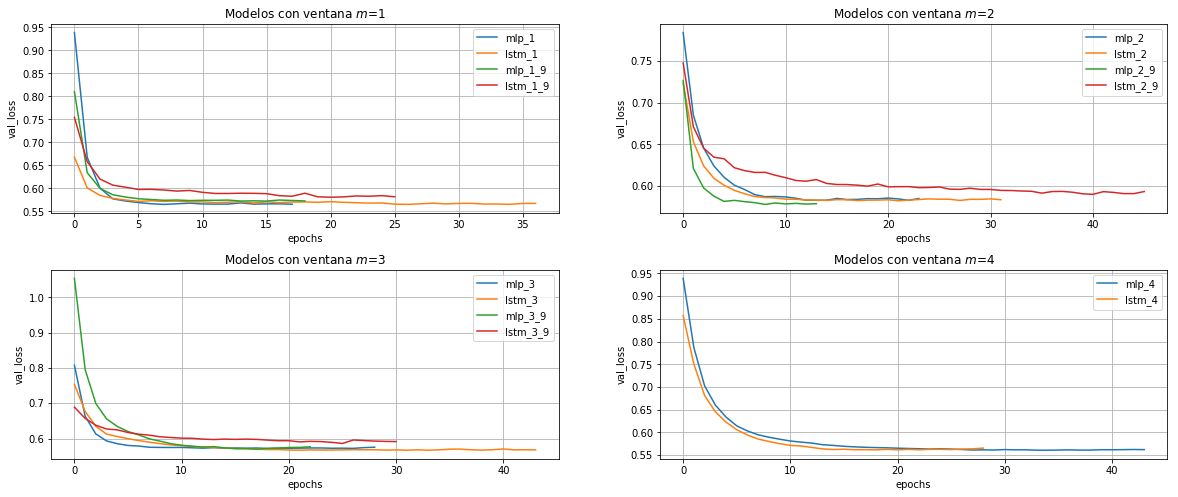

In [167]:
DrawValLossFromHistories(histories, "val_loss")

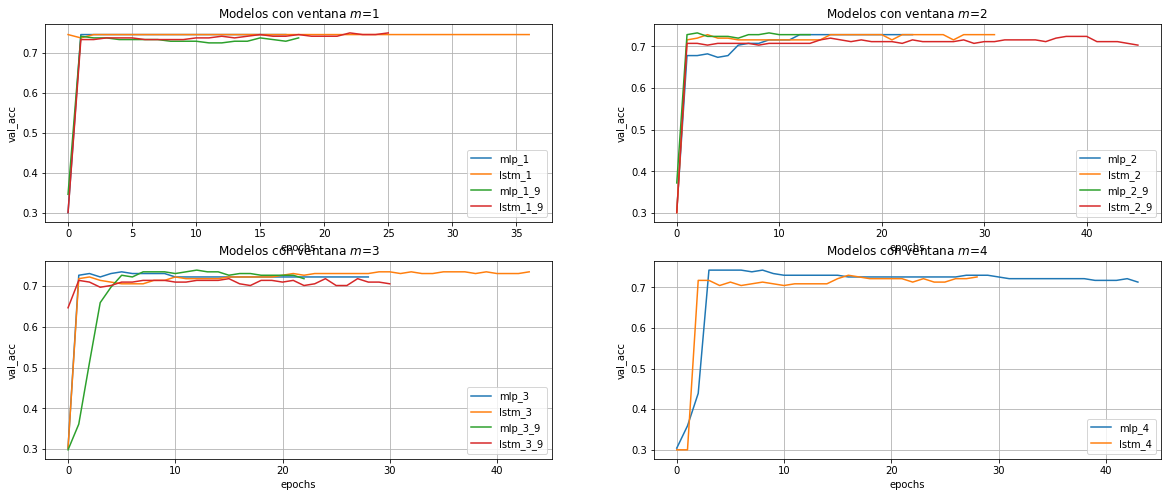

In [138]:
DrawValLossFromHistories(histories, "val_acc")